# Information Retrieval

## Overview

This lab provides hands-on practice building a complete **Search Engine** from scratch using **TF-IDF (Term Frequency-Inverse Document Frequency)**, one of the most common techniques in Information Retrieval. You'll work with real datasets, implement TF-IDF vectorization, measure document similarity using cosine similarity, and build a functional search engine that can retrieve and rank documents based on user queries. This lab demonstrates the practical application of IR concepts in building production-ready search systems.

> A 2015 survey showed that 83% of text-based recommender systems in digital libraries used TF-IDF.

## Outline

1. **Setup and Imports** - Installing dependencies and importing libraries
2. **Dataset Loading** - Loading the 20 Newsgroups dataset from scikit-learn
3. **Text Preprocessing** - Preparing documents for vectorization
4. **TF-IDF Vectorization** - Converting documents and queries into numerical vectors
5. **Building the Search Engine**:
   - **Retrieval**: Finding the most similar documents to a query using cosine similarity
   - **Ranking**: Ordering documents by relevance score
   - **Classification**: Classifying queries into one of the 20 categories
6. **Testing the Search Engine** - Querying and evaluating results
7. **Understanding Results** - Interpreting search results and similarity scores

## Learning Objectives

By the end of this lab, you will be able to:

- Recognize the term-document matrix produced by the TF-IDF algorithm
- Understand how similarity is measured between text vectors (cosine similarity)
- **Work with real datasets**.
- **Implement a TF-IDF-based search engine** using:
  - Scikit-learn's `TfidfVectorizer`
  - Cosine similarity for document ranking
  - Sparse matrices for efficient storage

## Glossary of Terms

**Information Retrieval (IR)**: The task of finding information (usually documents) that satisfies an information need from within large collections.

**Corpus**: A collection of documents. In IR, this is the entire set of documents we search through.

**Query**: A user's information need expressed in natural language (e.g., "What is machine learning?").

**Document**: A unit of information in the corpus (e.g., a web page, article, or text passage).

**TF-IDF (Term Frequency-Inverse Document Frequency)**: A numerical statistic that reflects how important a word is to a document in a collection. As you learned in the vectorization lesson:
- **TF (Term Frequency)**: How often a term appears in a document
- **IDF (Inverse Document Frequency)**: How rare or common a term is across the entire corpus
- **TF-IDF**: TF × IDF, giving higher weight to terms that are frequent in a document but rare in the corpus

**Vector Space Model**: A model where documents and queries are represented as vectors in a high-dimensional space. Similarity is measured using the angle between vectors (cosine similarity).

**Cosine Similarity**: A measure of similarity between two vectors. It measures the cosine of the angle between them, ranging from -1 to 1 (or 0 to 1 for non-negative vectors like TF-IDF).

**Sparse Matrix**: A matrix where most elements are zero. TF-IDF vectors are typically sparse because most words don't appear in most documents.

**Retrieval**: The process of finding and ranking documents in response to a query.

**Ranking**: Ordering retrieved documents by their relevance score (highest to lowest).

## References

- [20 Newsgroups Dataset](https://scikit-learn.org/stable/datasets/real_world.html#the-20-newsgroups-text-dataset)
- [Scikit-learn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Scikit-learn cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)

## The Complete Pipeline

1. **Dataset Loading**: Load the 20 Newsgroups dataset from scikit-learn
2. **Text Preprocessing**: Prepare documents for vectorization (as learned in previous lessons)
3. **TF-IDF Vectorization**: Convert documents and queries into numerical vectors
4. Model:
   1. **Retrieval**: Find the most similar documents to a query using **cosine similarity**
   2. **Classification**: Classify a query into one of the 20 categories

### Import Libraries

We group imports by category following Python best practices. All libraries used here are part of the standard scikit-learn ecosystem:


In [1]:
!pip install joblib==1.5.3 numpy==1.26.4 pandas==2.3.3 scikit-learn==1.8.0 --quiet 

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [2]:
# Standard library imports
import json
from collections import defaultdict

# Third-party imports
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("Libraries imported successfully!")

Libraries imported successfully!


## Loading the 20 Newsgroups Dataset

We'll use scikit-learn's **20 Newsgroups dataset**, a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. This is a classic dataset for text classification and information retrieval experiments.

**About the Dataset:**
- **20 categories** of newsgroups (e.g., comp.graphics, rec.sport.baseball, sci.med)
- Each document is a newsgroup post with subject and body text
- Documents are organized by topic, which we'll use to create relevance judgments

We'll load the 20 Newsgroups dataset using scikit-learn's `fetch_20newsgroups` function. This dataset contains newsgroup posts organized into 20 categories.


In [3]:
from sklearn.datasets import fetch_20newsgroups

In [ ]:
# fetch_20newsgroups?

In [4]:
# Load the 20 Newsgroups dataset
# We'll use the training set as our document collection
# remove=('headers', 'footers', 'quotes') removes metadata to focus on content
print("Loading 20 Newsgroups dataset...")
newsgroups = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42,
)

Loading 20 Newsgroups dataset...


### Exercise 1: Explore the Dataset

**Task:**

- The distribution of documents across categories
- The content of sample documents
- Notice that documents are organized by topic (category)

In [5]:
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': newsgroups.target,
    'category_name': [newsgroups.target_names[newsgroups.target[i]] for i in range(len(newsgroups.target))]
})
df.head()

,text,category,category_name
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


<Axes: xlabel='category'>

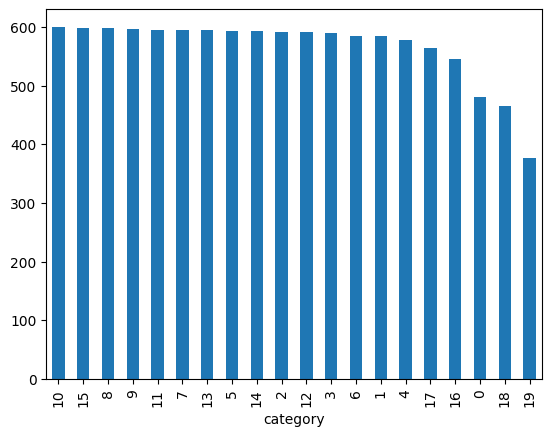

In [6]:
df['category'].value_counts().plot.bar()

### Drop columns and keep `text` only

In [7]:
df = df[['text']]
df

,text
0,I was wondering if anyone out there could enli...
1,A fair number of brave souls who upgraded thei...
2,"well folks, my mac plus finally gave up the gh..."
3,\nDo you have Weitek's address/phone number? ...
4,"From article <C5owCB.n3p@world.std.com>, by to..."
...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
11310,"I have a (very old) Mac 512k and a Mac Plus, b..."
11311,I just installed a DX2-66 CPU in a clone mothe...
11312,\nWouldn't this require a hyper-sphere. In 3-...


## Building the Search Engine

Now we'll build a TF-IDF-based search engine. The process involves:

1. **Creating TF-IDF vectors** for all documents
2. **Implementing a retrieval function**

### How TF-IDF enables retrieval

- TF-IDF weights words by their importance: rare words that appear frequently in a document get high scores
- When a user searches for "machine learning", documents with high TF-IDF scores for those terms are likely relevant
- The query is also converted to a TF-IDF vector, then compared to all document vectors

**Cosine Similarity for Document Matching**

To find relevant documents, we need to measure **similarity** between the query vector and document vectors. 

**Cosine Similarity** measures the angle between two vectors:
- It ranges from -1 to 1 (or 0 to 1 for non-negative vectors like TF-IDF)
- **1.0** = vectors point in the same direction (very similar)
- **0.0** = vectors are perpendicular (no similarity)
- **-1.0** = vectors point in opposite directions (very dissimilar)

**Why cosine similarity?**
- It measures similarity in **direction**, not magnitude
- A long document and a short document about the same topic will have similar directions (high cosine similarity)
- It's robust to document length differences
- Works well with sparse TF-IDF vectors

**The retrieval process:**
1. Convert query to TF-IDF vector (using the same vocabulary as documents)
2. Compute cosine similarity between query vector and all document vectors
3. Rank documents by similarity score (highest first)
4. Return top-k most similar documents

### Task 1: Creating TF-IDF vectors for all documents

In [8]:
# Step 2: Create TF-IDF vectors for all documents
# Initialize the vectorizer
# We use default settings, but you can customize:
# - max_features: limit vocabulary size
# - stop_words: remove common words ('english')
# - ngram_range: use unigrams and bigrams
vectorizer = TfidfVectorizer(
    lowercase=True,      # Convert to lowercase
    stop_words='english', # Remove English stop words
    max_features=5000,   # Limit vocabulary to top 5000 terms
    ngram_range=(1, 2)   # Use both unigrams and bigrams
)

In [9]:
# Fit on all documents and transform them
# This learns the vocabulary and IDF from the corpus
document_vectors = vectorizer.fit_transform(df['text'])
document_vectors

<11314x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 504091 stored elements in Compressed Sparse Row format>

In [10]:
print(f"Document vectors shape: {document_vectors.shape}")
print(f"  - {document_vectors.shape[0]} documents")
print(f"  - {document_vectors.shape[1]} features (terms in vocabulary)")
print("\nThis is a sparse matrix. Let's check sparsity:")
print(f"  - Non-zero elements: {document_vectors.nnz:,}")
print(f"  - Total elements: {document_vectors.shape[0] * document_vectors.shape[1]:,}")
print(f"  - Sparsity: {(1 - document_vectors.nnz / (document_vectors.shape[0] * document_vectors.shape[1])) * 100:.2f}%")

Document vectors shape: (11314, 5000)
  - 11314 documents
  - 5000 features (terms in vocabulary)

This is a sparse matrix. Let's check sparsity:
  - Non-zero elements: 504,091
  - Total elements: 56,570,000
  - Sparsity: 99.11%


> Notice how the sparse matrix efficiently stores only non-zero values. This is why TF-IDF scales well to large document collections.

- Document vectors shape: (~11,000, 5000) - thousands of documents, 5000 features
- High sparsity (typically 95-99%) - most values are zero

Notice how there is a lot of junk in the text, when we print the vocabulary from `200:400`, this may or may not be useful, depending on your use case.

In [11]:
# Show some vocabulary terms
vocab = vectorizer.get_feature_names_out()
print(vocab[200:400])

['42' '43' '44' '45' '46' '47' '48' '486' '49' '4e' '4k' '4l' '4t' '4th'
 '4u' '50' '500' '5000' '51' '52' '53' '54' '55' '56' '57' '58' '59' '5g'
 '5g9p' '5g9v' '5k' '5s' '5u' '60' '600' '6000' '61' '617' '62' '63' '64'
 '65' '650' '66' '67' '68' '69' '6e' '6ei' '6ei 6ei' '6g' '6um' '6um 6um'
 '70' '700' '703' '71' '72' '73' '74' '75' '750' '75u' '75u 75u' '76' '77'
 '78' '79' '7ex' '7ey' '7ey 7ey' '7ez' '7klj' '7kn' '7t' '7th' '7u' '80'
 '80 bit' '800' '81' '82' '83' '84' '85' '86' '87' '88' '89' '8n' '8v'
 '90' '900' '91' '91 92' '92' '93' '94' '95' '96' '97' '98' '99' '9d' '9f'
 '9f8' '9f9' '9l' '9l3' '9p' '9s' '9v' '9v g9v' '__' '___' '____' '_____'
 '_q' '_the' 'a4' 'a7' 'a86' 'a86 a86' 'a86 lg' 'a86r' 'ab' 'abc'
 'abiding' 'ability' 'able' 'abortion' 'abs' 'absolute' 'absolutely'
 'abuse' 'ac' 'ac uk' 'academic' 'accelerator' 'accept' 'acceptable'
 'accepted' 'access' 'accident' 'accidents' 'accomplished' 'according'
 'account' 'accounts' 'accurate' 'achieve' 'acid' 'acquired' '

### Task 2: Implementing a retrieval function

- Converts a query to a TF-IDF vector
- Computes cosine similarity with all document vectors
- Returns the top-k most similar documents

In [12]:
# Step 3: Implement the retrieval function
def retrieve_documents(query_text, top_k=10):
    # Transform query to TF-IDF vector using the same vectorizer
    query_vector = vectorizer.transform([query_text])
    
    # Compute cosine similarity between query and all documents
    # cosine_similarity returns a matrix of shape (1, num_documents)
    similarities = cosine_similarity(query_vector, document_vectors).flatten()
    
    # Get indices of top-k documents (sorted by similarity, descending)
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Return a dataframe with the top-k results
    df_results = df.iloc[top_indices].copy()
    df_results['similarity'] = similarities[top_indices]
    return df_results

In [13]:
search_results = retrieve_documents(query_text='computer', top_k=3)
search_results

,text,similarity
9137,\nWhat about the common joystick found in all ...,0.675917
8258,\n\nRumor has it that a guy at Dell Computer h...,0.650509
8464,\n Computers are a special case.. and it's a p...,0.517928


> **Note:** how the top three results are all related to the query.

## **Student Exercise**: build a search engine on the `CVs` dataset

In [ ]:
# STUDENT EXERCISE

In [17]:
import json
import os

base_folder = r"C:\Users\janah\OneDrive\سطح المكتب\SDAIA\week5\M1\DatasetCVs"
first_file = os.path.join(base_folder, "Topic_1", os.listdir(os.path.join(base_folder, "Topic_1"))[0])

with open(first_file, "r", encoding="utf-8") as f:
    data = json.load(f)

print(data)


{'Heading': 'Ahmed Al-Otaibi, AI Engineer', 'Skills': ['*', '**Programming', 'Languages:**', 'Python,', 'C++,', 'SQL. *', '**Machine', '&', 'Deep', 'Learning:**', 'PyTorch,', 'TensorFlow,', 'Scikit-learn,', 'Keras,', 'Hugging', 'Face', '(Transformers). *', '**Deployment', '&', 'Cloud', 'Computing:**', 'Docker,', 'Kubernetes,', 'AWS', '(SageMaker),', 'FastAPI,', 'CI/CD', 'Pipelines. *', '**Specializations:**', 'NLP', '(Natural', 'Language', 'Processing),', 'Computer', 'Vision,', 'Generative', 'AI.  ---'], 'Projects': ['Arabic Sentiment Analysis System | AI Model Developer [02/2023 - 05/2023]  Fine-tuned the AraBERT model on a dataset of over 100,000 tweets for dialect classification.  Achieved 94% accuracy, outperforming baseline models by 12%.', 'Defect Detection System in Manufacturing | Computer Vision Engineer [09/2022 - 12/2022]  Developed a YOLOv8 algorithm for real-time defect detection on production lines using video footage.  Reduced the false positive rate by 20%, which sped u

In [19]:
import os
import json
import pandas as pd

base_folder = r"C:\Users\janah\OneDrive\سطح المكتب\SDAIA\week5\M1\DatasetCVs"

all_docs = []

for topic_name in ["Topic_1", "Topic_2", "Topic_3"]:
    folder_path = os.path.join(base_folder, topic_name)
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
                
                combined_text = ""
                for key, value in data.items():
                    if isinstance(value, list):
                        combined_text += " ".join(value) + " "
                    else:
                        combined_text += str(value) + " "
                
                all_docs.append({
                    "topic": topic_name,
                    "filename": filename,
                    "text": combined_text.strip()
                })

df = pd.DataFrame(all_docs)
print(df.head())


     topic    filename                                               text
0  Topic_1  01_en.json  Ahmed Al-Otaibi, AI Engineer * **Programming L...
1  Topic_1  05_en.json  Layla Al-Harbi, AI Engineer * **Automation & P...
2  Topic_1     07.json  Fatima Al-Zahrani, AI Engineer * **Programming...
3  Topic_1     10.json  Ali Bin Nasser, AI Engineer * **Research Areas...
4  Topic_1     11.json  Nasser Al-Khaldi, AI Engineer * **Programming ...


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 2)
)

document_vectors = vectorizer.fit_transform(df['text'])

def retrieve_documents(query_text, top_k=3):
    query_vector = vectorizer.transform([query_text])
    similarities = cosine_similarity(query_vector, document_vectors).flatten()
    top_indices = np.argsort(similarities)[::-1][:top_k]
    df_results = df.iloc[top_indices].copy()
    df_results['similarity'] = similarities[top_indices]
    return df_results


search_results = retrieve_documents("AI Engineer Python", top_k=3)
print(search_results[['topic', 'filename', 'similarity']])


     topic    filename  similarity
4  Topic_1     11.json    0.165311
0  Topic_1  01_en.json    0.149569
8  Topic_1     21.json    0.147700


---

## Summary

### Key Takeaways

- **TF-IDF** is a simple but effective method for information retrieval
- **Sparse matrices** make TF-IDF scalable to large document collections

### Next Steps

- Explore other scikit-learn datasets (e.g., `fetch_20newsgroups` with different subsets)
- Try advanced techniques like BM25 (can be implemented with sklearn)